In [1]:
import sys, os
import dolfin as dfn
import numpy as np
import petsc4py as psc

sys.path.append('../')
# from femvf import meshutils, statefile as sf
# from femvf.forward import forward
# from femvf.adjoint import adjoint
from femvf.solids import Rayleigh, KelvinVoigt
from femvf.fluids import Bernoulli
from femvf.model import load_fsi_model
# from femvf.constants import PASCAL_TO_CGS
# from femvf.parameters.properties import SolidProperties, FluidProperties
# from femvf.parameters import parameterization
# from femvf.functionals import basic as funcs


In [2]:
mesh_dir = '../meshes'
mesh_base_filename = 'geometry2'
mesh_base_filename = 'M5-3layers-pressure-surface-refinement'

mesh_path = os.path.join(mesh_dir, mesh_base_filename + '.xml')

model = load_fsi_model(mesh_path, None, Solid=KelvinVoigt, Fluid=Bernoulli)
solid = model.solid

In [3]:
q, p, _ = model.get_pressure()
model.set_iter_params(qp1=(q, p))

In [4]:
## Assemble the matrices that will form the blocks of the block matrix
_df_du = model.assem_df1_du1_adj()
model.solid.bc_base.apply(_df_du)

df_du = dfn.as_backend_type(_df_du).mat()
df_dp = dfn.as_backend_type(dfn.assemble(solid.forms['form.bi.df1_dpressure_adj'])).mat()
dp_du, _ = model.get_flow_sensitivity()

In [5]:
## Try forming the block matrix
# [[df_du, df_du],
#  [df_du,     I]]

IJV_df_du = df_du.getValuesCSR()
IJV_df_dp = df_du.getValuesCSR()

shape_df_du = df_du.getSize()
shape_df_dp = df_dp.getSize()
shape_dp_du = dp_du.getSize()
M, N = shape_df_du[0]+shape_df_du[0], shape_df_du[1]+shape_df_du[1]


In [6]:
IJV_df_du

(array([    0,     6,    12, ..., 22748, 22758, 22768], dtype=int32),
 array([   0,    1,    2, ..., 1721, 1722, 1723], dtype=int32),
 array([ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -3.44946924e+05,  2.70260667e+05,  1.63985267e+06]))

In [7]:
df_du.getSize()
M, N

(3448, 3448)

In [8]:
# block_mat.setValuesCSR()
## Specify the set of blocks you want to form
blocks = [[df_du, df_du], 
          [df_du,     1]]

blocks = [[df_du, 0.0], 
          [0.0, df_du]]

# blocks = [[df_du]]

blocks = [[df_du, 0.0], 
          [0.0,   1.0]]

In [9]:
## Get the block sizes
# also check that the same number of columns are supplied in each row

M_BLOCK = len(blocks)
N_BLOCK = len(blocks[0])
for row in range(1, M_BLOCK):
    assert N_BLOCK == len(blocks[row])

In [12]:
## Calculate an array containing the n_rows in each row block
# and n_columns in each column block
block_row_sizes = -1*np.ones(M_BLOCK, dtype=np.intp)
block_col_sizes = -1*np.ones(N_BLOCK, dtype=np.intp)

# check that row/col sizes are consistent with the other row/col block sizes
for row in range(M_BLOCK):
    for col in range(N_BLOCK):
        block = blocks[row][col]
        shape = None
        if isinstance(block, psc.PETSc.Mat):
            shape = block.getSize()
        elif isinstance(block, (int, float)):
            # Use -1 to indicate a variable size 'diagonal' matrix, that will adopt 
            # the shape of neighbouring blocks to form a proper block matrix
            shape = (-1, -1)
        else:
            print('uhoh')
            raise ValueError("Blocks can only be matrices or floats")
            
        for block_sizes in (block_row_sizes, block_col_sizes):
            if block_sizes[row] == -1:
                block_sizes[row] = shape[0]
            else:
                assert (block_sizes[row] == shape[0] 
                        or shape[0] == -1)

# get the row and column sizes for the blocks
block_row_sizes = np.where(block_row_sizes == -1, 1, block_row_sizes)
block_col_sizes = np.where(block_col_sizes == -1, 1, block_col_sizes)

print(block_row_sizes)

[1724    1]


In [14]:
## Calculate a list of column offsets along column blocks
block_row_offsets = [0] + np.cumsum(block_row_sizes).tolist()[:-1]
block_col_offsets = [0] + np.cumsum(block_col_sizes).tolist()[:-1]

print(block_col_offsets)

[0, 1724]


In [15]:
# Grab all the CSR format values and put them into a block list form
i_block = []
j_block = []
v_block = []

for row in range(M_BLOCK):
    i_block_row = []
    j_block_row = []
    v_block_row = []
    for col in range(N_BLOCK):
        block = blocks[row][col]
        if isinstance(block, psc.PETSc.Mat):
            i, j, v = block.getValuesCSR()
            i_block_row.append(i)
            j_block_row.append(j)
            v_block_row.append(v)
        else:
            # In this case the block should just be a constant value, like 1.0
            # to indicate an identity matrix
            i_block_row.append(None)
            j_block_row.append(None)
            v_block_row.append(block)
    i_block.append(i_block_row)
    j_block.append(j_block_row)
    v_block.append(v_block_row)

In [33]:
## Generate the CSR format for the monolithic matrix corresponding to the block form
i_mono = [0]
j_mono = []
v_mono = []
    
for row in range(M_BLOCK):
    for local_row in range(block_row_sizes[row]):
        j_mono_row = []
        v_mono_row = []
        for col in range(N_BLOCK):
            # get the CSR data associated with the specific block
            i, j, v = i_block[row][col], j_block[row][col], v_block[row][col]
            
            # if the block is not a matrix, handle this case as if it's a diagonal block
            if i is None:
                if v != 0 or row == col:
                    # only set the 'diagonal' if the matrix dimension is appropriate
                    # i.e. if the block is a tall rectangular one, don't keep 
                    # writing diagonals when the row index > # cols since this is 
                    # undefined
                    if local_row < block_col_sizes[col]:
                        j_mono_row += [local_row + block_col_offsets[col]]
                        v_mono_row += [v]
            else:
                istart = i[local_row]
                iend = i[local_row+1]
                
                j_mono_row += (j[istart:iend] + block_col_offsets[col]).tolist()
                v_mono_row += v[istart:iend].tolist()
        i_mono += [i_mono[-1] + len(v_mono_row)]
        j_mono += j_mono_row
        v_mono += v_mono_row
print(df_du.size)  
print(block_row_sizes)
print(block_col_sizes)
print(len(i_mono))
i_mono = np.array(i_mono, dtype=np.int32)
j_mono = np.array(j_mono, dtype=np.int32)
v_mono = np.array(v_mono, dtype=np.float)

(1724, 1724)
[1724    1]
[1724    1]
1726


In [39]:
## Create a monolithic matrix to contain the block matrix
block_mat = psc.PETSc.Mat()
block_mat.create(psc.PETSc.COMM_SELF)
block_mat.setSizes([np.sum(block_row_sizes), np.sum(block_col_sizes)])

block_mat.setUp()

print(block_mat.getSize())
print(np.array(j_mono))

## Insert the values into the matrix
nnz = i_mono[1:] - i_mono[:-1]
block_mat.setPreallocationNNZ(nnz)
block_mat.setValuesCSR(i_mono, j_mono, v_mono)

(1725, 1725)
[   0    1    2 ... 1722 1723 1724]
22769


In [40]:
## Assemble the block matrix now that you're all done
block_mat.assemble()
# block_mat.assemblyBegin()
# block_mat.assemblyEnd()

In [41]:
## Test solving systems using the matrix
A = block_mat

True
seqaij
{'assemblies': 1.0,
 'block_size': 1.0,
 'factor_mallocs': 0.0,
 'fill_ratio_given': 0.0,
 'fill_ratio_needed': 0.0,
 'mallocs': 0.0,
 'memory': 421368.0,
 'nz_allocated': 22769.0,
 'nz_unneeded': 0.0,
 'nz_used': 22769.0}


<IPython.core.display.Javascript object>


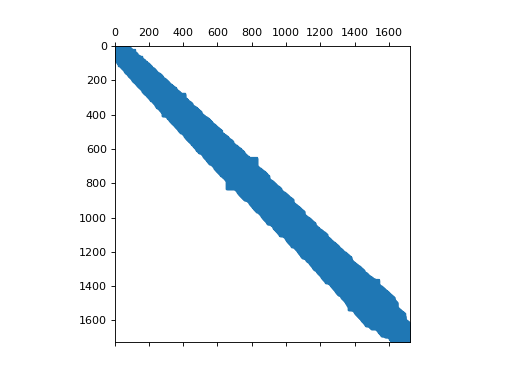

In [42]:
%matplotlib notebook
## Check how many nonzero elements there are / sparsity / etc.
print(A.isAssembled())

print(A.getType())

from pprint import pprint
pprint(A.getInfo())

import matplotlib.pyplot as plt
from scipy import sparse

i, j, v = A.getValuesCSR()
Z = sparse.csr_matrix((v, j, i), shape=A.size)
plt.spy(Z)

In [43]:
## Get vectors to store solutions with
x, b = A.getVecs()

In [44]:
## Test multiplication with a vector
b[1] = 20
b[2] = 900
b.array[:] = 3

ans = A * b
print(ans.array)

A[:3, :3]
# [ 0.00000000e+00  0.00000000e+00 -4.84001143e+06 ... -4.50014679e+06
#  -4.87904929e+06  3.00000000e+00]

[3.00000000e+00 3.00000000e+00 4.06789338e+04 ... 4.05087337e+04
 4.05087337e+04 3.00000000e+00]


array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [-1.20602429e+04, -3.17785235e+04,  1.62689679e+06]])

In [45]:
## Test using KSP via LU factorization
ksp = psc.PETSc.KSP().create()
ksp.setType(ksp.Type.PREONLY)
print(ksp.getType())

pc = ksp.getPC()
pc.setType(pc.Type.LU)
print(pc.getType())

ksp.setOperators(A)
ksp.solve(b, x)

x.array

preonly
lu


array([3.00000000e+00, 3.00000000e+00, 1.04303799e+00, ...,
       2.15146635e-04, 2.30839750e-04, 3.00000000e+00])